In [535]:
import datetime
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r_2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import warnings

warnings.filterwarnings('ignore')
mpl.rcParams.update({'font.size': 13})

### Read data

In [557]:
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [350]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [7]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


### EDA and clean data

***

In [9]:
def reduce_mem_df(df):
    start_mem = df.memory_usage().sum() / 1024
    print(f'Memory usage start {start_mem} KB')

    for column in df.columns:
        col_type = df[column].dtype

        if col_type.kind != 'O':
            col_min = df[column].min()
            col_max = df[column].max()

            if df[column].dtype.kind == 'i':
                for int_param in [np.int8, np.int16, np.int32]:
                    if col_min > np.iinfo(int_param).min and col_max < np.iinfo(int_param).max:
                        df[column] = df[column].astype(int_param)
            else:
                for float_param in [np.float16, np.float32]:
                    if col_min > np.finfo(float_param).min and col_max < np.finfo(float_param).max:
                        df[column] = df[column].astype(float_param)
        else:
            df[column] = df[column].astype('category')

    end_mem = df.memory_usage().sum() / 1024
    print(f'memory after reduce {end_mem}')
    return df

# reduce_mem_df(df_train)
# reduce_mem_df(df_test)

Memory usage start 1562.625 KB
memory after reduce 693.84765625
Memory usage start 742.3125 KB
memory after reduce 327.63671875


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.84375,19.09375,5.0,5,9.0,1970,0.036133,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.50000,42.56250,10.0,7,17.0,2017,0.072144,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.46875,NaN,9.0,19,19.0,1977,0.211426,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.65625,33.90625,6.0,2,2.0,1965,0.014076,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.84375,NaN,1.0,8,17.0,1977,0.309570,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.18750,30.34375,5.0,6,5.0,1962,0.069641,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.68750,94.50000,10.0,21,27.0,2018,0.060760,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.65625,19.00000,5.0,2,5.0,1966,0.038696,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.62500,20.96875,9.0,8,14.0,1970,0.089050,B,B,33,7976,5,NaN,0,11,B


Text(0.5, 1.0, 'Price of df_train')

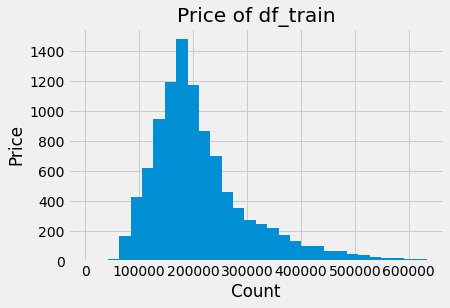

In [116]:
""" show on price"""
# plt.figure(figsize=(12, 8))
plt.style.use('fivethirtyeight')

plt.hist(df_train['Price'], bins=30)
plt.xlabel('Count')
plt.ylabel('Price')
plt.title('Price of df_train')

In [17]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315613,37.199677,6.273300,8.526700,12.609400,3.990166e+03,0.118856,24.687000,5352.157400,8.039200,1142.905029,1.319500,4.231300,214138.859375
std,0.839512,21.058096,86.234680,28.560917,5.241148,6.775974,2.005003e+05,0.119024,17.532614,4006.799803,23.831875,1021.544495,1.493601,4.806341,92872.289062
min,0.000000,1.136719,0.370605,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.781250,22.765625,1.000000,4.000000,9.000000,1.974000e+03,0.017654,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.500000,32.781250,6.000000,7.000000,13.000000,1.977000e+03,0.075439,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.875000,45.125000,9.000000,12.000000,17.000000,2.001000e+03,0.195801,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.000000,7480.000000,2014.000000,42.000000,117.000000,2.005201e+07,0.521973,74.000000,19083.000000,141.000000,4848.000000,6.000000,23.000000,633233.437500


In [20]:
df_train.select_dtypes(include=object).columns.tolist()

['Id', 'DistrictId']

In [43]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [ ]:
df_train['KitchenSquare'].value_counts()

In [57]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [58]:
df_train['Floor'].value_counts()

4     949
5     876
3     871
6     802
7     759
8     643
9     604
2     591
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    255
1     235
18    185
19    121
20     68
21     59
24     53
22     53
25     34
23     25
26     18
27      5
28      3
32      2
31      1
33      1
42      1
37      1
Name: Floor, dtype: int64

In [113]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  object 
 11  Ecology_3           10000 non-null  object 
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Healthcare_1        5204 non-null   float64
 16  Helth

***
### Conclusion

In [558]:
class DataPreprocessing:
    def __init__(self):
        self.median = None
        self.quantile_kitchen_square_975 = None

    def transform_df(self, df):
        df = self.room_preprocessing(df)
        df = self.kitchen_preprocessing(df)
        df = self.house_floor_preprocessing(df)
        df = self.floor_preprocessing(df)
        df = self.house_year_preprocessing(df)
        df = self.life_square_preprocessing(df)
        return df

    def fit_median_quantile(self, df):
        self.median = df.median()
        self.quantile_kitchen_square_975 = df['KitchenSquare'].quantile(0.975)

    @staticmethod
    def data_astype(df):
        df['Id'] = df['Id'].astype(str)
        df['DistrictId'] = df['DistrictId'].astype(str)
        return df

    def room_preprocessing(self, df):
        df = self.room_outlier(df)
        df.loc[df_train['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df_train['Rooms'] > 6, 'Rooms'] = df['Rooms'].median()
        return df

    def kitchen_preprocessing(self, df):
        filter = (df['KitchenSquare'] > self.quantile_kitchen_square_975) |\
                 (df['KitchenSquare'].isna())

        df.loc[filter, 'KitchenSquare'] = self.median['KitchenSquare']
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        return df

    def house_floor_preprocessing(self, df):
        df = self.house_floor_outlier(df)
        df.loc[(df['HouseFloor'] == 0) |
                    (df['HouseFloor'] > 95), 'HouseFloor'] = self.median['HouseFloor']
        return df

    def floor_preprocessing(self, df):
        floor_outlier_index = df.loc[df['Floor'] > df['HouseFloor']].index

        df.loc[floor_outlier_index, 'Floor'] = df.loc[floor_outlier_index, 'HouseFloor']\
            .apply(lambda x: random.randint(1, x))
        return df

    def house_year_preprocessing(self, df):
        curent_data = datetime.datetime.now().year

        df.loc[df['HouseYear'] > curent_data, 'HouseYear'] = curent_data
        return df

    def life_square_preprocessing(self, df):
        life_square_condition = (df['LifeSquare'].isna()) &\
                        (~df['Square'].isna()) &\
                        (~df['KitchenSquare'].isna())

        df.loc[life_square_condition, 'LifeSquare'] = df.loc[life_square_condition, 'Square'] -\
                                                    df.loc[life_square_condition, 'KitchenSquare']
        return df

    def room_outlier(self, df):
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 6), 'Rooms_outlier'] = 1
        return df

    def house_floor_outlier(self, df):
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['HouseFloor'] < df['Floor'], 'HouseFloor_outlier'] = 1
        return df

data_preprocessing = DataPreprocessing()
data_preprocessing.fit_median_quantile(df_train)
data_preprocessing.transform_df(df_train)
data_preprocessing.transform_df(df_test)

data_preprocessing.data_astype(df_train)
data_preprocessing.data_astype(df_test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,0,0
2,960,27,2.0,59.463678,50.463678,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,0,0
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B,0,0
4,746,74,1.0,53.837056,50.837056,3.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,4,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B,0,1
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B,0,0


In [560]:
# df_train
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
0,11809,27,3.0,115.027311,105.027311,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,37.409907,3.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855,0,0


In [440]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_outlier
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,8383.40770,50.400800,1.888000,56.315775,41.368574,6.238200,7.416200,12.931500,1984.872800,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.00110,0.182500
std,4859.01902,43.587592,0.812479,21.058732,77.727715,2.794717,5.039436,6.241322,18.417132,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.03315,0.386275
min,0.00000,0.000000,1.000000,1.136859,0.370619,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.00000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,25.470423,3.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.00000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,36.555426,6.000000,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.00000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,49.388022,8.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.00000,0.000000
max,16798.00000,209.000000,6.000000,641.065193,7480.592129,13.000000,42.000000,48.000000,2022.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.00000,1.000000


***
### Built new sign


In [377]:
df_train['HouseYear'].sort_values().value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1947       1
1928       1
1916       1
1914       1
1910       1
Name: HouseYear, Length: 96, dtype: int64

In [561]:
class FeatureGenerator:

    def __init__(self, df):
        self.df_median = df.median()

    def feature_generate(self, df):
        self.binary_replace(df)
        df = self.district_size(df)
        self.district_big(df)
        # self.price_median_district(df)
        self.floor_category(df)
        self.year_category(df)
        return df
        # self.price_median_year(df)

    def binary_replace(self, df):
        sign_to_binary = {'A': 0, 'B': 1}

        df['Ecology_2'] = df['Ecology_2'].replace(sign_to_binary)
        df['Ecology_3'] = df['Ecology_3'].replace(sign_to_binary)
        df['Shops_2'] = df['Shops_2'].replace(sign_to_binary)

    def district_size(self, df):
        df_district_id = df['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId':'DistrictSize'})

        return df.merge(df_district_id, on='DistrictId', how='left')


    def district_big(self, df):
        df['District_big'] = (df['DistrictSize'] > 100).astype(int)

    # def price_median_district(self,df):
    #     df_med_price_group = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'PriceMedian_district'})
    #     df = df.merge(df_med_price_group, on=['DistrictId', 'Rooms'], how='left')

    def floor_category(self, df):
        df['Floor_category'] = pd.cut(df['Floor'], (df['Floor'].min(), 3, 8, 13, df['Floor'].max() + 1), labels=False, right=False)
        df['Floor_category'].fillna(-1, inplace=True)

    def year_category(self, df):
        bins_bool = (df['HouseYear'].min()-1, 1950, 2000, df['HouseYear'].max())
        df_year_cut = pd.cut(df['HouseYear'], bins=bins_bool, labels=False)
        df_year_cut.fillna(-1, inplace=True)
        df['Year_category'] = df_year_cut

    # def price_median_year(self, df):
    #     median_price_year_floor = df.groupby(['Year_category', 'Floor_category'], as_index=False)\
    #         .agg({'Price':'median'}).rename(columns={'Price': 'PriceMedian_Year'})
    #     df = df.merge(median_price_year_floor, on=['Year_category', 'Floor_category'], how='left')

    @staticmethod
    def drop_sign(df):
        df.drop(['Id', 'DistrictId' , 'Healthcare_1'], axis=1, inplace=True)

    def replace_fillna_median(self, df):
        df.fiilna(self.df_median, inplac=True)


feat_generation = FeatureGenerator(df_train)
df_train = feat_generation.feature_generate(df_train)
df_test = feat_generation.feature_generate(df_test)

In [563]:
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,District_big,Floor_category,Year_category
0,11809,27,3.0,115.027311,105.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.871089,0,0,851,1,1,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407,0,0,78,0,1,1
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850,0,0,652,1,0,1
3,2352,1,1.0,40.409907,37.409907,3.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.007630,0,0,652,1,2,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.102962,0,0,89,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,1,1,52,10311,6,NaN,1,9,1,119367.455796,0,0,118,1,1,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,199715.148807,0,1,851,1,3,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,1,1,20,4386,14,NaN,1,5,1,165953.912580,0,0,7,0,1,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.411855,0,0,165,1,1,1


In [564]:
pd.options.display.max_columns = None
feat_generation.drop_sign(df_train)
feat_generation.drop_sign(df_test)

## 3 train test split

In [569]:
x = df_train.drop('Price', axis=1)
y = pd.DataFrame(df_train['Price'], columns=['Price'])
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=49, shuffle=True)

In [574]:
x_train

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,DistrictSize,District_big,Floor_category,Year_category
7825,3.0,95.388336,94.732596,3.0,1,1.0,2014,0.041125,1,1,46,9515,5,1,10,1,0,1,90,0,0,2
9883,3.0,63.167270,45.647059,6.0,2,9.0,1977,0.012339,1,1,35,5776,1,2,4,1,0,0,129,1,0,1
9304,3.0,117.237801,62.361490,6.0,2,15.0,2008,0.035145,1,1,42,9292,3,0,3,1,0,0,78,0,0,2
2091,2.0,64.356748,61.356748,3.0,2,3.0,1977,0.437885,1,1,23,5735,3,0,5,1,0,0,179,1,0,1
9115,2.0,71.304763,68.304763,3.0,13,20.0,1977,0.072158,1,1,2,629,1,0,0,0,0,0,247,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8050,1.0,40.235879,22.564419,10.0,17,22.0,1987,0.188784,1,1,31,6137,4,0,1,1,0,0,119,1,3,1
7924,2.0,67.078934,64.078934,3.0,5,17.0,1977,0.075779,1,1,6,1437,3,0,2,1,0,0,565,1,1,1
3254,3.0,77.891596,74.891596,3.0,8,17.0,1977,0.007122,1,1,1,264,0,0,1,1,0,0,652,1,2,1
5805,1.0,48.105228,45.105228,3.0,16,17.0,1977,0.243205,1,1,5,1564,0,0,0,1,0,0,511,1,3,1


***
## 4 data processing use model

In [465]:
# reduce_mem_df(x_train)
# reduce_mem_df(x_valid)

Memory usage start 1230.46875 KB
memory after reduce 656.25


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,Floor_category,Year_category,DistrictSize,District_big
7825,3.0,95.37500,94.75000,3.0,1.0,1.0,2014,0.041138,1,1,46,9515,5,1,10,1,0,0,0,2,90,0
9883,3.0,63.15625,45.65625,6.0,2.0,9.0,1977,0.012337,1,1,35,5776,1,2,4,1,0,0,0,1,129,1
9304,3.0,117.25000,62.37500,6.0,2.0,15.0,2008,0.035156,1,1,42,9292,3,0,3,1,0,0,0,2,78,0
2091,2.0,64.37500,61.34375,3.0,2.0,3.0,1977,0.437988,1,1,23,5735,3,0,5,1,0,0,0,1,179,1
9115,2.0,71.31250,68.31250,3.0,13.0,20.0,1977,0.072144,1,1,2,629,1,0,0,0,0,0,3,1,247,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8050,1.0,40.25000,22.56250,10.0,17.0,22.0,1987,0.188843,1,1,31,6137,4,0,1,1,0,0,3,1,119,1
7924,2.0,67.06250,64.06250,3.0,5.0,17.0,1977,0.075806,1,1,6,1437,3,0,2,1,0,0,1,1,565,1
3254,3.0,77.87500,74.87500,3.0,8.0,17.0,1977,0.007122,1,1,1,264,0,0,1,1,0,0,2,1,652,1
5805,1.0,48.09375,45.09375,3.0,16.0,17.0,1977,0.243164,1,1,5,1564,0,0,0,1,0,0,3,1,511,1


In [468]:
model_scale = StandardScaler()
x_train = model_scale.fit_transform(x_train)
x_valid = model_scale.transform(x_valid)

## test model learn

In [575]:
model_regressor = BaggingRegressor(n_estimators=180, max_features=15, max_samples=720, oob_score='r2', random_state=49)
model_regressor.fit(x_train, y_train)
y_pred_valid = model_regressor.predict(x_valid)
r_2(y_valid, y_pred_valid)

0.7117992118600124

In [576]:
y_pred_train = model_regressor.predict(x_train)
r_2(y_train, y_pred_train)

0.7557037325335731

In [527]:
def model_bagging(x_train, x_valid, y_train, y_valid):
    r2_train_list = list()
    r2_valid_list = list()
    for val in np.arange(710, 810, 10):
        model_regressor = BaggingRegressor(n_estimators=180, max_features=15, max_samples=val, random_state=49)
        model_regressor.fit(x_train, y_train)
        y_pred_valid = model_regressor.predict(x_valid)
        y_pred_train = model_regressor.predict(x_train)
        r2_valid = r_2(y_valid, y_pred_valid)
        r2_train = r_2(y_train, y_pred_train)
        r2_train_list.append(r2_train)
        r2_valid_list.append(r2_valid)
        print(r2_valid, 'R2 valid', '\n',
              r2_train, 'R2 train', '\t',  f'value {val}', '\n')
    return r2_train_list, r2_valid_list

r2_train, r2_valid = model_bagging(x_train, x_valid, y_train, y_valid)

0.7132489537901588 R2 valid 
 0.7553287750939452 R2 train 	 value 710 

0.7148135992601867 R2 valid 
 0.7561739308811268 R2 train 	 value 720 

0.7125338453464168 R2 valid 
 0.7566124551412432 R2 train 	 value 730 

0.7130430332851261 R2 valid 
 0.7583109574251619 R2 train 	 value 740 

0.7136339910101099 R2 valid 
 0.7584531721075652 R2 train 	 value 750 

0.7125474542647908 R2 valid 
 0.7583273391688183 R2 train 	 value 760 

0.7110661019033844 R2 valid 
 0.7593625206440001 R2 train 	 value 770 

0.7114524571145211 R2 valid 
 0.7601386886304802 R2 train 	 value 780 

0.7127092477329383 R2 valid 
 0.762295774290753 R2 train 	 value 790 

0.7122287891353759 R2 valid 
 0.762354920312901 R2 train 	 value 800 



In [ ]:
x_train = model_scale.inverse_transform(x_train)
x_valid = model_scale.inverse_transform(x_valid)

## BaggingRegressor
max_features = 15
max_samples=val = 720
n_estimators = 180
***
R2_valid = 0.7148135

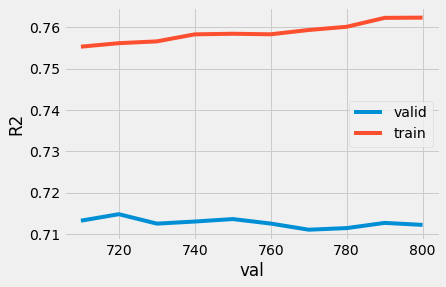

In [529]:
x_axes = np.arange(710, 810, 10)
plt.style.use('fivethirtyeight')
plt.plot(x_axes, r2_valid, label='valid')
plt.plot(x_axes, r2_train, label='train')
plt.xlabel('val')
plt.ylabel('R2')
plt.legend()

***

In [548]:
def scale_data(x_tr, x_val):
    model_scale = RobustScaler()
    x_train = model_scale.fit_transform(x_tr)
    x_valid = model_scale.transform(x_val)
    return x_train, x_valid

In [546]:
def model_gradient(x_train, x_valid, y_train, y_valid):
    r2_train_list = list()
    r2_valid_list = list()
    for val in np.arange(100, 150, 5):
        model_regressor = GradientBoostingRegressor(n_estimators=val, max_depth=5, max_features=18, random_state=49)
        model_regressor.fit(x_train, y_train)
        y_pred_valid = model_regressor.predict(x_valid)
        y_pred_train = model_regressor.predict(x_train)
        r2_valid = r_2(y_valid, y_pred_valid)
        r2_train = r_2(y_train, y_pred_train)
        r2_train_list.append(r2_train)
        r2_valid_list.append(r2_valid)
        print(r2_valid, 'R2 valid', '\n',
              r2_train, 'R2 train', '\t',  f'value {val}', '\n')
    return r2_train_list, r2_valid_list

r2_train, r2_valid = model_gradient(x_train, x_valid, y_train, y_valid)

0.7584897387537013 R2 valid 
 0.8577894095610265 R2 train 	 value 100 

0.7589856132796376 R2 valid 
 0.8610135275574037 R2 train 	 value 105 

0.7589609203604644 R2 valid 
 0.8641741747174505 R2 train 	 value 110 

0.7579621732342052 R2 valid 
 0.8665149797472055 R2 train 	 value 115 

0.7582217419847712 R2 valid 
 0.8703752097624418 R2 train 	 value 120 

0.7579367078714248 R2 valid 
 0.8727021320250109 R2 train 	 value 125 

0.7579749752822251 R2 valid 
 0.8750147855330648 R2 train 	 value 130 

0.7582681037120687 R2 valid 
 0.8785568702600735 R2 train 	 value 135 

0.7585728879246948 R2 valid 
 0.8807564522345305 R2 train 	 value 140 

0.7588337837507853 R2 valid 
 0.8822713273041206 R2 train 	 value 145 



### GradientBoostingRegressor

n_estimators = 100
max_depth = 5
max_features = 18
***
R2 = 0.7584

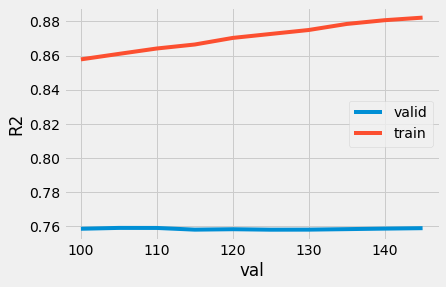

In [547]:
x_axes = np.arange(100, 150, 5)
plt.style.use('fivethirtyeight')
plt.plot(x_axes, r2_valid, label='valid')
plt.plot(x_axes, r2_train, label='train')
plt.xlabel('val')
plt.ylabel('R2')
plt.legend()

## I chose model and suitable parameters

In [549]:
x_train, x_test = scale_data(x_train, x_valid)

In [578]:

def get_result(x_train, x_valid, y_train, y_valid, x_test):
    model_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=5, max_features=18, random_state=49)
    model_regressor.fit(x_train, y_train)
    y_pred_test = model_regressor.predict(x_test)
    y_pred_valid = model_regressor.predict(x_valid)
    y_pred_train = model_regressor.predict(x_train)
    r2_valid = r_2(y_valid, y_pred_valid)
    r2_train = r_2(y_train, y_pred_train)
    print(r2_valid, 'R2 valid', '\n',
              r2_train, 'R2 train', '\t')
    return y_pred_test

y_pred_result = get_result(x_train, x_valid, y_train, y_valid, x_test)

0.7501262731067215 R2 valid 
 0.860805978901262 R2 train 	


In [579]:
df_id = pd.read_csv('datasets/sample_submission.csv')

In [581]:
df_id['Price'] = y_pred_result

In [585]:
df_id.to_csv('df_submit_2.csv', index=False)